## Train Model

The idea of this step is to leverage existing state of the art models such as Ince

# Create image generators

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json
from PIL import Image

In [3]:
def generate_generator_multiple(generator,directories, batch_size, img_height,img_width):
    generators =[]
    for directory in directories:
        gen = generator.flow_from_directory(directory,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=True, 
                                          seed=7)
    
        generators.append(gen)

    for gen in generators:
        for data, labels in gen:
            yield data, labels

In [4]:
def save_plots(history,target_file_acc,target_file_loss):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(target_file_acc)
    plt.close()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(target_file_loss)
    plt.close()

In [5]:
def show_plots(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Doing K-Folds

In [6]:
batch_size = 32
img_height=80
img_width = 256
approx_fold_size = 300

In [7]:
urban_sounds_folder = "/home/nvidia/soundflux_data/spectrograms"

In [8]:
fold_directories = []
for i in range(1,11):
    directory = urban_sounds_folder+"/fold"+str(i)
    fold_directories.append(directory)

In [9]:
fold_directories

['/home/nvidia/soundflux_data/spectrograms/fold1',
 '/home/nvidia/soundflux_data/spectrograms/fold2',
 '/home/nvidia/soundflux_data/spectrograms/fold3',
 '/home/nvidia/soundflux_data/spectrograms/fold4',
 '/home/nvidia/soundflux_data/spectrograms/fold5',
 '/home/nvidia/soundflux_data/spectrograms/fold6',
 '/home/nvidia/soundflux_data/spectrograms/fold7',
 '/home/nvidia/soundflux_data/spectrograms/fold8',
 '/home/nvidia/soundflux_data/spectrograms/fold9',
 '/home/nvidia/soundflux_data/spectrograms/fold10']

# MODEL

In [10]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.2,
                            zoom_range=0.3,
                            #horizontal_flip=True,
                            #vertical_flip=True,
                            fill_mode='nearest')
testdatagen = ImageDataGenerator(rescale=1./255)
#datagen = ImageDataGenerator(horizontal_flip=True)

In [11]:
input_shape = (img_height, img_width,3)
nclass = 4

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers

Next ideas:

- Add filters on time with strides! 2,1 convolutions with padding and a gap
- Keep at least a good 64 channels open?
- Sum pooling instead of averaging?

# try 

keras.applications.densenet.DenseNet121 next

In [13]:
input_shape = (img_height,img_width,3)
permute = (2,3,1)
new_input_shape = (img_width,1,img_height,3)
conv_input_shape = (img_width,1,img_height,3)
model = keras.models.Sequential()
model.add(keras.layers.Permute(permute, input_shape=input_shape))
#model.add(keras.layers.Reshape((1,1, img_width, 3*img_height), input_shape=(img_width,img_height,3)))
model.add(keras.layers.Reshape(conv_input_shape, input_shape=new_input_shape))
#
#model.add(keras.layers.Conv3D(32,(2,1,2),activation='relu'))
#model.add(keras.layers.AveragePooling3D((1,1,2)))
model.add(keras.layers.ConvLSTM2D(64, kernel_size=(1, 4),activation='tanh',
                                  input_shape=new_input_shape,
                                   padding='same', return_sequences=True
                                 ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AveragePooling3D((2,1,3)))
model.add(keras.layers.Conv3D(32,(2,1,2),activation='relu',input_shape=input_shape))
model.add(keras.layers.AveragePooling3D((2,1,3)))
model.add(keras.layers.Conv3D(32,(2,1,2),activation='relu',input_shape=input_shape))
#model.add(keras.layers.Conv2D(64,(2,2),activation='relu'))
#model.add(keras.layers.AveragePooling2D((2,2)))
#model.add(keras.layers.Conv2D(128,(1,2),activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(nclass, activation=tf.nn.softmax))


In [14]:
opt = optimizers.RMSprop(lr=0.001)
#opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])
#needed to reset weigh"""ts!
model.save_weights('raw_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 256, 3, 80)        0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 1, 80, 3)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 256, 1, 80, 64)    68864     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 1, 80, 64)    256       
_________________________________________________________________
average_pooling3d (AveragePo (None, 128, 1, 26, 64)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 127, 1, 25, 32)    8224      
_________________________________________________________________
average_pooling3d_1 (Average (None, 63, 1, 8, 32)      0         
__________

**LSTM Sizing**
This is helpful when understanding sizing
https://stackoverflow.com/questions/50242925/data-preprocessing-input-shape-for-timedistributed-cnn-lrcn-convlstm2d-for?rq=1

**Explore**
- Should also be returning state?
- Should also flip sizing? (channel representation should be 3 instead of the height?)
- Run another LSTM from top to bottom to traverse from the spectrums/frequency bands from lower to higher!?!

# Folding

https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

In [15]:
num_folds = 1 #1 to 10
fold = 0
for directory in fold_directories:
    fold +=1
    #RESET WEIGHTS!!
    #model.load_weights('raw_model.h5')
    #
    #FORCE A DIFFERENT FOLD OF THE DATA:
    if directory == '/home/nvidia/soundflux_data/spectrograms/fold1':
        continue
    train_directories = list(set(fold_directories) - set([directory]))
    test_directories = [directory]
    #HACK IT
    #train_directories = ["/home/nvidia/soundflux_data/spectrograms/fold1","/home/nvidia/soundflux_data/spectrograms/fold2"]
    #test_directories = ["/home/nvidia/soundflux_data/spectrograms/fold3"]
    print("Running fold {}, holding data from {} and training on the remaining {}" \
          .format(fold,directory,len(train_directories)))
    train_generator = generate_generator_multiple(generator=datagen,
                                           directories = train_directories,
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_width)
    test_generator = generate_generator_multiple(generator=testdatagen,
                                       directories = test_directories,
                                       batch_size=batch_size,
                                       img_height=img_height,
                                       img_width=img_width)
    history = model.fit_generator(train_generator,
                              steps_per_epoch=approx_fold_size*9/batch_size,
                              epochs=30,
                              validation_data = test_generator,
                              validation_steps=approx_fold_size/batch_size,
                              shuffle=True, 
                              verbose=True)
    model.save_weights('trained_model_fold_{}.h5'.format(fold))
    with open('training_history_fold_{}.json'.format(fold), 'w') as f:
        json.dump(history.history, f)
    save_plots(history,'training_accuracy_plot_fold_{}.png'.format(fold),
               'training_lossaccuracy_plot_fold_{}.png'.format(fold))
    if fold >= num_folds:
        break

Running fold 2, holding data from /home/nvidia/soundflux_data/spectrograms/fold2 and training on the remaining 9
Epoch 1/30
Found 309 images belonging to 4 classes.
Found 363 images belonging to 4 classes.
Found 257 images belonging to 4 classes.
Found 298 images belonging to 4 classes.
Found 256 images belonging to 4 classes.
Found 245 images belonging to 4 classes.
Found 248 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 248 images belonging to 4 classes.
85/84 [==============================] - 433s 5s/step - loss: 1.1220 - acc: 0.6673 - val_loss: 1.2599 - val_acc: 0.5600
Epoch 2/30
85/84 [==============================] - 402s 5s/step - loss: 0.4578 - acc: 0.8328 - val_loss: 1.1675 - val_acc: 0.5167
Epoch 3/30
85/84 [==============================] - 403s 5s/step - loss: 0.3356 - acc: 0.8737 - val_loss: 0.9056 - val_acc: 0.6033
Epoch 4/30
85/84 [==============================] - 401s 5s/step - loss: 0.2577 - acc: 0.9131 - val_loss: 0.6680 - val_acc: 0

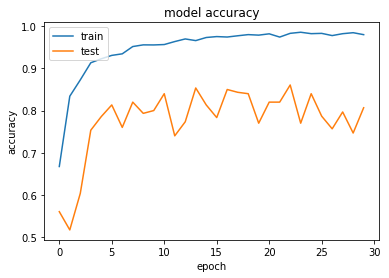

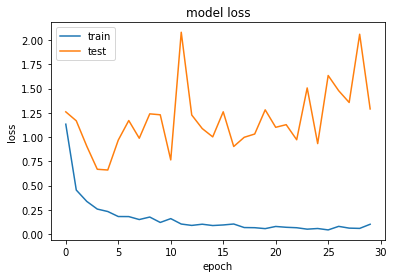

In [16]:
show_plots(history)

Try this: https://mc.ai/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and/

In [17]:
test_generator = generate_generator_multiple(generator=testdatagen,
                                       directories = test_directories,
                                       batch_size=batch_size,
                                       img_height=img_height,
                                       img_width=img_width)

#experiment with different data gen
train_generator = generate_generator_multiple(generator=datagen,
                                       directories = train_directories,
                                       batch_size=batch_size,
                                       img_height=img_height,
                                       img_width=img_width)
model.evaluate_generator(test_generator,
                              steps=approx_fold_size/batch_size,
                              verbose=True)

Found 268 images belonging to 4 classes.
10/9 [================================] - 16s 2s/step


[1.3590638256072998, 0.813333334128062]